<a href="https://www.kaggle.com/code/dalloliogm/submission-ensemble?scriptVersionId=239892564" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import pandas as pd
import re

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import re
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Folder containing the submission files
submission_folder = "/kaggle/input/elucidata-submissions"


# Store predictions and weights
predictions = []
weights = []
submission_names = []

# Extract and process all submission files
pattern = re.compile(r"submission_(\d+)\.csv")
for fname in os.listdir(submission_folder):
    match = pattern.match(fname)
    if not match:
        continue

    score_str = match.group(1)
    weight = float("0." + score_str.lstrip("0"))

    df = pd.read_csv(os.path.join(submission_folder, fname))
    pred_cols = [col for col in df.columns if col != "ID"]
    df_pred = df[pred_cols].copy()

    predictions.append(df_pred)
    weights.append(weight)
    submission_names.append(fname)

# Convert to numpy array
pred_array = np.stack([df.values for df in predictions], axis=-1)  # (N, C, M)
weights = np.array(weights)
weights = weights / weights.sum()  # Normalize

n_samples, n_targets, n_models = pred_array.shape
ID = df["ID"]
columns = predictions[0].columns

# === 1. Global Weighted Average Ensemble ===
ensemble_global = np.average(pred_array, axis=-1, weights=weights)
pd.DataFrame({"ID": ID, **dict(zip(columns, ensemble_global.T))}).to_csv(
    "ensemble_global_weighted.csv", index=False
)

# === 2. Per-Feature Weighted Average ===
per_feature_weights = np.tile(weights, (n_targets, 1))  # (C, M)
per_feature_weights = per_feature_weights / per_feature_weights.sum(axis=1, keepdims=True)
ensemble_feature = np.einsum('ncm,cm->nc', pred_array, per_feature_weights)
pd.DataFrame({"ID": ID, **dict(zip(columns, ensemble_feature.T))}).to_csv(
    "ensemble_per_feature_weighted.csv", index=False
)

# === 3. Greedy Ensemble (pseudo ground truth = global weighted) ===
val_labels = ensemble_global.copy()
used = [np.argmax(weights)]
ensemble = pred_array[:, :, used[0]]
for i in range(n_models):
    if i in used:
        continue
    candidate = (ensemble * len(used) + pred_array[:, :, i]) / (len(used) + 1)
    if mean_squared_error(val_labels, candidate) < mean_squared_error(val_labels, ensemble):
        ensemble = candidate
        used.append(i)
ensemble_greedy = ensemble
pd.DataFrame({"ID": ID, **dict(zip(columns, ensemble_greedy.T))}).to_csv(
    "ensemble_greedy.csv", index=False
)

# === 4. Stacking (Ridge regression per target) ===
final_preds = np.zeros((n_samples, n_targets))
X_all = np.transpose(pred_array, (0, 2, 1))  # (N, M, C)
for i in range(n_targets):
    X_meta = X_all[:, :, i]  # (N, M)
    y_meta = val_labels[:, i]
    model = Ridge()
    model.fit(X_meta, y_meta)
    final_preds[:, i] = model.predict(X_meta)
ensemble_stacking = final_preds
pd.DataFrame({"ID": ID, **dict(zip(columns, ensemble_stacking.T))}).to_csv(
    "ensemble_stacking.csv", index=False
)

print("✅ Saved all 4 ensemble submissions:")
print("- ensemble_global_weighted.csv")
print("- ensemble_per_feature_weighted.csv")
print("- ensemble_greedy.csv")
print("- ensemble_stacking.csv")



✅ Saved all 4 ensemble submissions:
- ensemble_global_weighted.csv
- ensemble_per_feature_weighted.csv
- ensemble_greedy.csv
- ensemble_stacking.csv


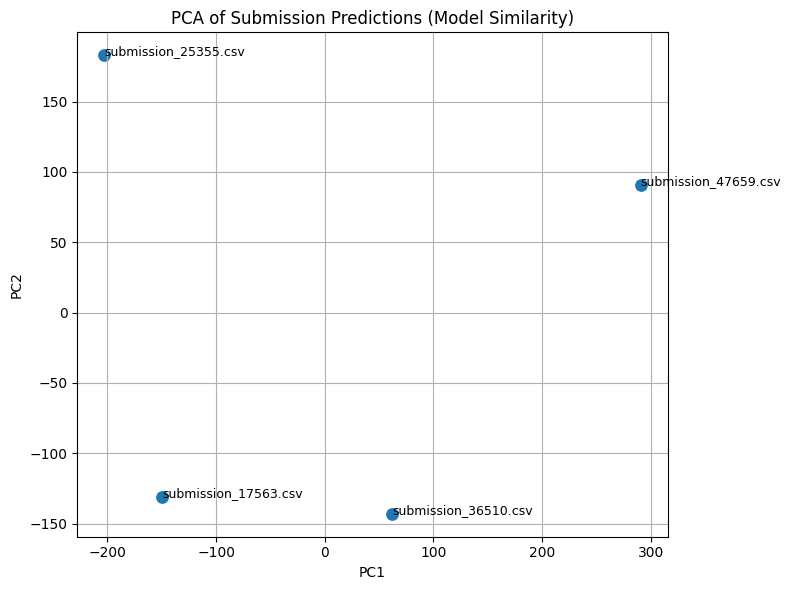

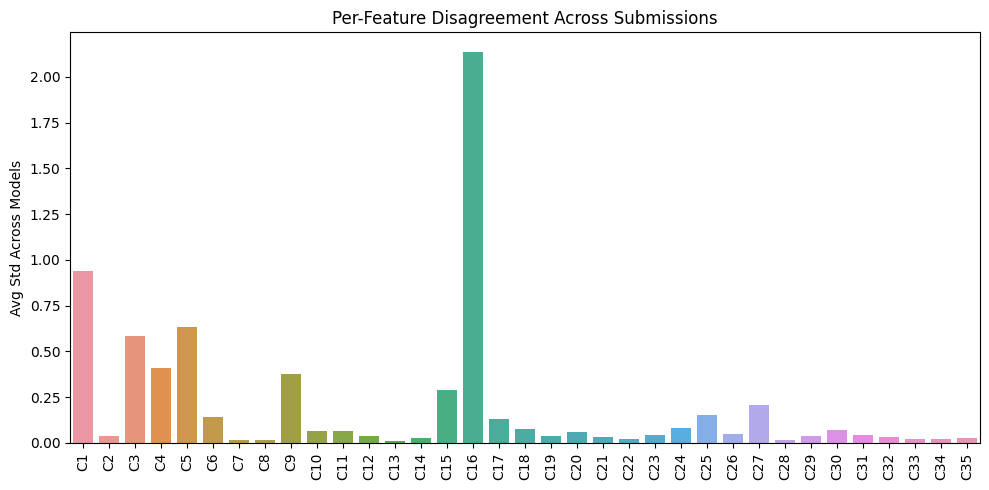

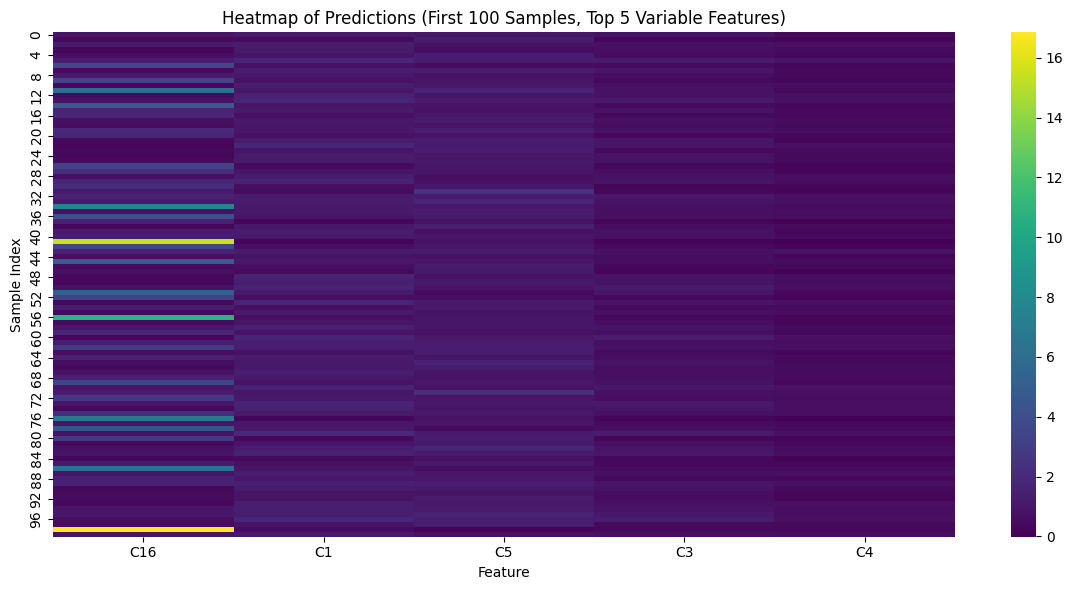

In [2]:
# ======================
# 🔍 Visualizations
# ======================

# -------- 1. PCA across submissions (model similarity) --------
# Flatten each submission (N samples * C features) for PCA
submission_vectors = [df.values.flatten() for df in predictions]
submission_matrix = np.stack(submission_vectors)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(StandardScaler().fit_transform(submission_matrix))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], s=100)
for i, name in enumerate(submission_names):
    plt.text(pca_result[i, 0], pca_result[i, 1], name, fontsize=9)
plt.title("PCA of Submission Predictions (Model Similarity)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

# -------- 2. Concordance per prediction target (feature agreement) --------
# Compute std across models for each (sample, feature), then average over samples
feature_std = np.std(pred_array, axis=-1)  # shape: (N, C)
feature_disagreement = np.mean(feature_std, axis=0)  # shape: (C,)

plt.figure(figsize=(10, 5))
sns.barplot(x=predictions[0].columns, y=feature_disagreement)
plt.xticks(rotation=90)
plt.ylabel("Avg Std Across Models")
plt.title("Per-Feature Disagreement Across Submissions")
plt.tight_layout()
plt.show()

# -------- 3. Heatmap of first 100 samples across top 5 features --------
# Pick top 5 variable features
top_features = np.argsort(-feature_disagreement)[:5]
sample_subset = pred_array[:100, top_features, :]  # shape: (100, 5, M)
avg_preds = sample_subset.mean(axis=-1)  # shape: (100, 5)

plt.figure(figsize=(12, 6))
sns.heatmap(avg_preds, xticklabels=[predictions[0].columns[i] for i in top_features], cmap="viridis")
plt.title("Heatmap of Predictions (First 100 Samples, Top 5 Variable Features)")
plt.xlabel("Feature")
plt.ylabel("Sample Index")
plt.tight_layout()
plt.show()

